# LPC experiment

LPCNet(https://jmvalin.ca/demo/lpcnet/) is based on LPC, so basic understanding is needed.

based on https://ccrma.stanford.edu/~hskim08/lpc/ , but the mathematical equation in that article is not optimized.

The LPC filter is all pole filter simulating human vocal track:

 - Z-domain: $ H(Z) = \frac{1}{1 - \sum_{p=1}^{P} a_{p}Z^{-p}} $
 - Time-domain: $ s[k] = e[k] + \sum_{p=1}^{P} a_{p}s[k-p]  $
     - $e[k]$ is excitation/residual signal emitted at the beginning of the vocal track
     - $s[k]$ is the sound signal at the end of the vocal track

To estimate filter coefficients $a_{1} ... a_{P}$ and residual signal $e[k]$ from sound signal $s[k]$, an assumption about signal $e[k]$ is made to minimize it's power (WHY?):

 $ J = \sum_{k} e[k]^{2} = \sum_{k} \left( s[k] - \sum_{p=1}^{P} a_{p}s[k-p] \right)^{2}  $

The minimal should happen at $ \frac{\partial J}{\partial a_{i}} = \sum_{k} \left( 2 (s[k] - \sum_{p=1}^{P} a_{p}s[k-p]) (-s[k-i]) \right) = 0 $

which can be simplified as
$$
\begin{alignat*}{1}
& \frac{\partial J}{\partial a_{i}} = \sum_{k} \left( (s[k] - \sum_{p=1}^{P} a_{p}s[k-p]) s[k-i] \right) \\
&  = \sum_{k} s[k]s[k-i] - \sum_{k}\sum_{p=1}^{P} a_{p}s[k-p]s[k-i] \\
&  = \sum_{k} s[k]s[k-i] - \sum_{p=1}^{P} a_{p} (\sum_{k} s[k-p]s[k-i]) = 0
\end{alignat*}
$$

Notice that $\sum_{k} s[k-p]s[k-i]$ is actually the correlation between signal s[k] delayed by p and i time steps respectively : $C_{ip} = C_{pi}$, then we can simplify the notation as:
$$ C_{0i} - \sum_{p=1}^{P} a_{p}C_{ip} = 0 $$

for all P such equation i=1...P we have a linear system to solve:
$$
\begin{bmatrix}
   C_{01} \\
   C_{02} \\
   ... \\
   C_{0P}
\end{bmatrix} = 

\begin{bmatrix}
C_{11} & C_{12} & ... & C_{1P} \\
C_{21} & C_{22} & ... & C_{2P} \\
... \\
C_{P1} & C_{P2} & ... & C_{PP} \\
\end{bmatrix}

\begin{bmatrix}
   a_{1} \\
   a_{2} \\
   ... \\
   a_{P}
\end{bmatrix}

$$


In [8]:
import numpy as np
import scipy, scipy.io, scipy.io.wavfile, scipy.signal
import IPython
import matplotlib.pyplot as plt
from vscode_audio import Audio
from lpc_helper import *
%matplotlib inline

In [9]:
wave=np.array([1,2,3,4])
autocorr = scipy.signal.correlate(wave[3:], wave, "valid")
print(autocorr)
print(scipy.signal.correlate([1,2,3], [3,4,0], "valid"))

[16 12  8  4]
[11]


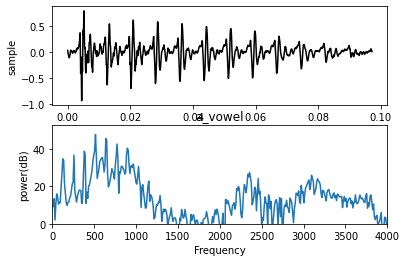

a=[ 1.         -2.33592975  1.57115165 -0.09811385 -0.07166005 -0.08637501
  0.24570869 -0.25359299 -0.06785189 -0.02700373  0.15683548 -0.07414034
  0.0815921  -0.01516684  0.08582521 -0.16093822  0.04772928 -0.05713628
  0.09524681 -0.00383759 -0.02217383]
e=[ 0.03512573 -0.05394455  0.00857557 ...  0.00092376  0.00014284
 -0.00372359]


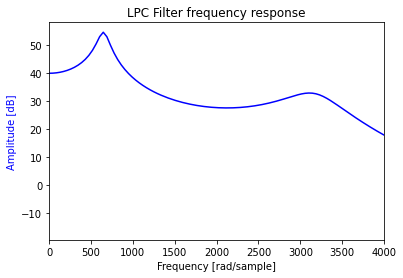

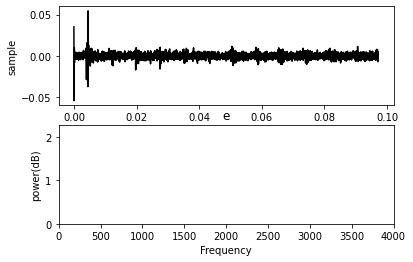

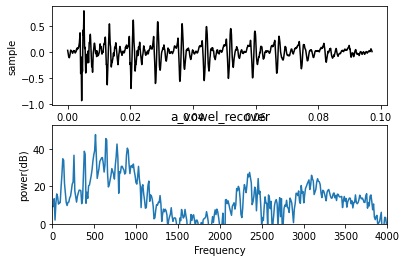

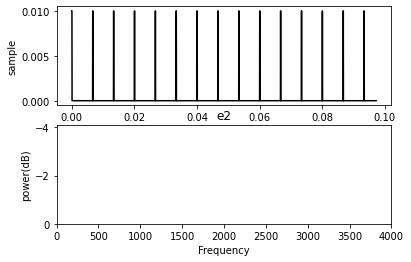

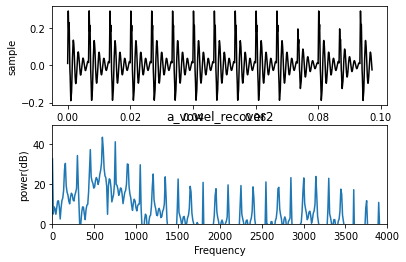

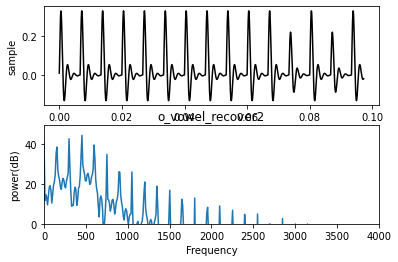

In [10]:
# load two test sounds
a_vowel = load_wave("wavs/aww.wav")
o_vowel = load_wave("wavs/oh.wav")
sr = 44100

# play the sounds
play_sound(a_vowel, rate=sr, name="a_vowel")
#play_sound(o_vowel)

"""Compute LPC:
a: the LPC's IIR filter coefficients a
e: the error/residual

This method is not optimized.
"""
def lpc0(wave, order):
    N = order
    yAll = wave
    b = wave[N:]
    cnt = len(b)
    A = yAll[N-1:N-1+cnt].reshape((cnt,1))
    for i in range(2, N+1):
        A = np.hstack((A, yAll[N-i:(N-i+cnt)].reshape((cnt,1))))
    
    a = np.linalg.inv(A.T.dot(A)).dot(A.T.dot(b))
    e = b-A.dot(a)
    return np.concatenate(([1],-a)),e

def lpc1(wave, order):
    K = len(wave) - order
    def C(i, j):
        return scipy.signal.correlate(wave[i:i+K], wave[j:j+K], "valid")[0]
    
    M = np.zeros((order, order))
    b = np.zeros((order, 1))

    for i in range(order):
        b[i,0] = C(0, i+1)
        for j in range(i, order):
            M[j, i] = M[i, j] = C(i+1, j+1)
    
    a = np.linalg.solve(M, b)
    a = np.squeeze(a)
    a = np.concatenate(([1],-a))

    # reverse filter to get e
    e = scipy.signal.lfilter(a, [1], wave)
    return a,e

lpc = lpc1

a, e = lpc(a_vowel, 20)

def quantize(x, QMAX):
    vmax = np.amax(x)
    s = QMAX/vmax
    print(s)
    q = np.clip((x * s).astype(np.int32), -QMAX, QMAX)
    return q.astype(np.float32) / s

a_vowel_recover = scipy.signal.lfilter([1], a, e)

print("a={} e={}".format(a, e))

w, h = scipy.signal.freqz([1], a)
plt.figure()
plt.plot(w*sr/2/np.pi, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.xlim(0, 4000)
plt.title("LPC Filter frequency response")

play_sound(e, rate=sr, name="e")
play_sound(a_vowel_recover, rate=sr, name="a_vowel_recover")

f = 150
e2 = (scipy.signal.square(2*np.pi*f*np.arange(len(e))/(sr), 0.01) + 1)*0.005

play_sound(e2, rate=sr, name="e2")

o, _ = lpc(o_vowel, 10)
play_sound(scipy.signal.lfilter([1], a, e2), rate=sr, name="a_vowel_recover2")
play_sound(scipy.signal.lfilter([1], o, e2), rate=sr, name="o_vowel_recover2")

# LPCNet

https://jmvalin.ca/demo/lpcnet/

The basic idea seems to be derive LPC filter from input text(how?), and LPC filter can give good prediction which simplifies the RNN's work to only predict errors.

## how LPC filter is derived from input text?